# **Amazon.com---Employee-Access-Challenge**

When an employee at any company starts work, they first need to obtain the computer access necessary to fulfill their role. This access may allow an employee to read/manipulate resources through various applications or web portals. It is assumed that employees fulfilling the functions of a given role will access the same or similar resources. It is often the case that employees figure out the access they need as they encounter roadblocks during their daily work (e.g. not able to log into a reporting portal). A knowledgeable supervisor then takes time to manually grant the needed access in order to overcome access obstacles. As employees move throughout a company, this access discovery/recovery cycle wastes a nontrivial amount of time and money.

There is a considerable amount of data regarding an employee’s role within an organization and the resources to which they have access. Given the data related to current employees and their provisioned access, models can be built that automatically determine access privileges as employees enter and leave roles within a company. These auto-access models seek to minimize the human involvement required to grant or revoke employee access.

## **Objective**

The objective of this competition is to build a model,learned using historical data, that will determine an employee's access needs, such that manual access transactions (grants and revokes) are minimized as the employee's attributes change over time. The model will take an employee's role information and a resource code and will return whether or not access should be granted.

The data consists of real historical data collected from 2010 & 2011. Employees are manually allowed or denied access to resources over time. You must create an algorithm capable of learning from this historical data to predict approval/denial for an unseen set of employees.

## **Data**

File Descriptions
train.csv - The training set. Each row has the ACTION (ground truth), RESOURCE, and information about the employee's role at the time of approval

test.csv - The test set for which predictions should be made. Each row asks whether an employee having the listed characteristics should have access to the listed resource.

## **Column Descriptions**

Column Name Description ACTION ACTION is 1 if the resource was approved, 0 if the resource was no

RESOURCE An ID for each resource

MGR_ID The EMPLOYEE ID of the manager of the current EMPLOYEE ID record; an employee may have only one manager at a time

ROLE_ROLLUP_1 Company role grouping category id 1 (e.g. US Engineering)

ROLE_ROLLUP_2 Company role grouping category id 2 (e.g. US Retail)

ROLE_DEPTNAME Company role department description (e.g. Retail)

ROLE_TITLE Company role business title description (e.g. Senior Engineering Retail Manager)

ROLE_FAMILY_DESC Company role family extended description (e.g. Retail Manager, Software Engineering)

ROLE_FAMILY Company role family description (e.g. Retail Manager)

ROLE_CODE Company role code; this code is unique to each role (e.g. Manager)

## Import Library & Dataset

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('amazon-employee-access-challenge_train.csv')
print(data.shape)
data.head()

(32769, 10)


,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


## Data Exploration

In [3]:
data_explore = data.copy()

In [4]:
data_explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32769 entries, 0 to 32768
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   ACTION            32769 non-null  int64
 1   RESOURCE          32769 non-null  int64
 2   MGR_ID            32769 non-null  int64
 3   ROLE_ROLLUP_1     32769 non-null  int64
 4   ROLE_ROLLUP_2     32769 non-null  int64
 5   ROLE_DEPTNAME     32769 non-null  int64
 6   ROLE_TITLE        32769 non-null  int64
 7   ROLE_FAMILY_DESC  32769 non-null  int64
 8   ROLE_FAMILY       32769 non-null  int64
 9   ROLE_CODE         32769 non-null  int64
dtypes: int64(10)
memory usage: 2.5 MB


There is no column with null values.

In [5]:
data_explore.nunique()

ACTION                 2
RESOURCE            7518
MGR_ID              4243
ROLE_ROLLUP_1        128
ROLE_ROLLUP_2        177
ROLE_DEPTNAME        449
ROLE_TITLE           343
ROLE_FAMILY_DESC    2358
ROLE_FAMILY           67
ROLE_CODE            343
dtype: int64

- In dataset description it is mention that an employee can have only one manager at a time, then we can consider that the dataset contains information of maximum 4243 employees.
- There are same number of unique values for ROLE_TITLE and ROLE_CODE. There is 1-to-1 mapping between these columns. So for our problem only one feature is sufficent.

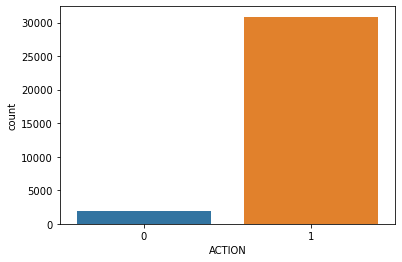

In [6]:
sns.countplot(x='ACTION', data=data_explore)

- We can see that we have imbalance dataset. There are very less records of not granting the access.

- Lets find out top 15 Resources, Role department, Role family, Role codes for which most access is requested.

In [7]:
data_explore_resources = data_explore[['RESOURCE', "ACTION"]].groupby(by='RESOURCE').count()
data_explore_resources.sort_values('ACTION', ascending=False).head(n=15).transpose()

RESOURCE,4675,79092,25993,75078,3853,75834,6977,32270,42085,17308,1020,13878,42093,18418,7543
ACTION,839,484,409,409,404,299,299,295,247,239,236,220,204,192,186


In [8]:
data_explore_role_dept = data_explore[['ROLE_DEPTNAME', "ACTION"]].groupby(by='ROLE_DEPTNAME').count()
data_explore_role_dept.sort_values('ACTION', ascending=False).head(n=15).transpose()

ROLE_DEPTNAME,117878,117941,117945,118514,117920,117884,119598,118403,119181,120722,118320,117895,118746,118783,120663
ACTION,1135,763,659,601,597,546,543,532,525,501,435,431,415,366,335


In [9]:
data_explore_role_codes = data_explore[['ROLE_CODE', "ACTION"]].groupby(by='ROLE_CODE').count()
data_explore_role_codes.sort_values('ACTION', ascending=False).head(n=15).transpose()

ROLE_CODE,118322,117908,118786,117880,118570,117888,118055,118687,118779,118454,120346,118332,119082,117973,118425
ACTION,4649,3583,1772,1256,1043,806,774,597,566,521,473,467,394,384,376


In [10]:
data_explore_role_family = data_explore[['ROLE_FAMILY', "ACTION"]].groupby(by='ROLE_FAMILY').count()
data_explore_role_family.sort_values('ACTION', ascending=False).head(n=15).transpose()

ROLE_FAMILY,290919,118424,19721,117887,292795,118398,308574,118453,118331,118643,118638,270488,118295,118960,118205
ACTION,10980,2690,2636,2400,1318,1294,1287,941,892,783,783,689,493,465,449


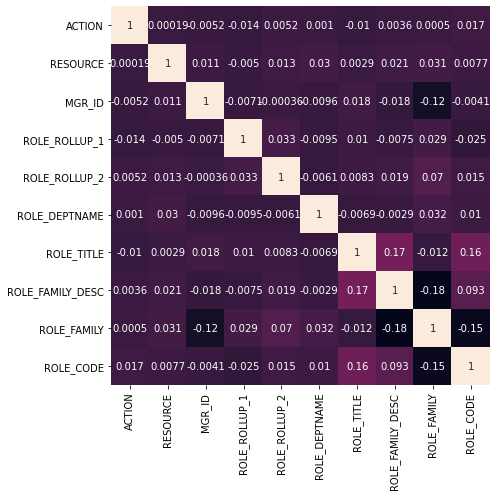

In [11]:
plt.figure(figsize=(12, 7))
corr_matrix = data_explore.corr()
sns.heatmap(corr_matrix, mask=np.zeros_like(corr_matrix, dtype=np.bool), square=True, annot=True, cbar=False)
plt.tight_layout()

In [12]:
corr_matrix['ACTION'].sort_values(ascending=False)

ACTION              1.000000
ROLE_CODE           0.017147
ROLE_ROLLUP_2       0.005179
ROLE_FAMILY_DESC    0.003565
ROLE_DEPTNAME       0.001025
ROLE_FAMILY         0.000502
RESOURCE            0.000185
MGR_ID             -0.005167
ROLE_TITLE         -0.010169
ROLE_ROLLUP_1      -0.013702
Name: ACTION, dtype: float64

- There is no attribute to which target variable is strongly correlated.

## Data Preprocessing

In [13]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [14]:
X = data.drop(columns=['ACTION'], axis=1).copy()
y = data['ACTION'].copy()
X.shape, y.shape

((32769, 9), (32769,))

In [15]:
cat_attrs = list(X.columns)
cat_attrs

['RESOURCE',
 'MGR_ID',
 'ROLE_ROLLUP_1',
 'ROLE_ROLLUP_2',
 'ROLE_DEPTNAME',
 'ROLE_TITLE',
 'ROLE_FAMILY_DESC',
 'ROLE_FAMILY',
 'ROLE_CODE']

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(X, y):
    strat_train_set = data.iloc[train_index]
    strat_test_set = data.iloc[test_index]

X_train = strat_train_set.drop('ACTION', axis=1)
y_train = strat_train_set['ACTION'].copy()
X_test = strat_test_set.drop('ACTION', axis=1)
y_test = strat_test_set['ACTION'].copy()
X_train.shape, X_test.shape

((26215, 9), (6554, 9))

In [17]:
cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                         ('cat_enc', OneHotEncoder(handle_unknown='ignore'))])

pre_process = ColumnTransformer([('cat_process', cat_pipeline, cat_attrs)], remainder='passthrough')

X_train_transformed = pre_process.fit_transform(X_train)
X_test_transformed = pre_process.transform(X_test)
X_train_transformed.shape, X_test_transformed.shape

((26215, 14410), (6554, 14410))

- Since I will be using CatBoost Classifier. For CatBoost model, there is no need of encoding categorical model. Hence I will be creating a separate preprocessing pipeline for CatBoost model.

In [18]:
cat_boost_pre_process = ColumnTransformer([('imputer', SimpleImputer(strategy='most_frequent'), cat_attrs)], remainder='passthrough')

X_cb_train_transformed = cat_boost_pre_process.fit_transform(X_train)
X_cb_test_transformed = cat_boost_pre_process.transform(X_test)
X_cb_train_transformed.shape, X_cb_test_transformed.shape

((26215, 9), (6554, 9))

In [19]:
feature_columns = list(pre_process.transformers_[0][1]['cat_enc'].get_feature_names(cat_attrs))
len(feature_columns)

14410

## Modelling

- Evaluation metric for this competition is ROC AUC Score.
- Since we have imbalance dataset, I will use Matthews correlation coefficient (MCC) as another evaluation metric. 
- Value of MCC is lies between -1 to +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction.
    - ${MCC} = \frac{(TP + TN) * (FP + FN)}{\sqrt{( (TP +FP) * (TP + FN) * (TN + FP) * (TN + FN))}}$
    
- MCC value will be high only if model has high accuracy on predictions of negative data instances as well as of positive data instances.
- I will be selecting the best model with highest ROC AUC Score.

In [20]:
from sklearn.model_selection import KFold, cross_val_score

kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [21]:
from sklearn.metrics import matthews_corrcoef, make_scorer, roc_auc_score, roc_curve
Matthew = make_scorer(matthews_corrcoef)

results = []

def plot_custom_roc_curve(clf_name, y_true, y_scores):
    auc_score = np.round(roc_auc_score(y_true, y_scores), 3)
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    plt.plot(fpr, tpr, linewidth=2, label=clf_name+" (AUC Score: {})".format(str(auc_score)))
    plt.plot([0, 1], [0, 1], 'k--') # Dashed diagonal
    plt.axis([0, 1, 0, 1])
    plt.xlabel("FPR", fontsize=16)
    plt.ylabel("TPR", fontsize=16)
    plt.legend()
    
    
def performance_measures(model, X_tr=X_train_transformed, y_tr=y_train, X_ts=X_test_transformed, y_ts=y_test,
                         store_results=True):
    train_mcc = cross_val_score(model, X_tr, y_tr, scoring=Matthew, cv=kf, n_jobs=-1)
    test_mcc = cross_val_score(model, X_ts, y_ts, scoring=Matthew, cv=kf, n_jobs=-1)
    print("Mean Train MCC: {}\nMean Test MCC: {}".format(train_mcc.mean(), test_mcc.mean()))

    
    train_roc_auc = cross_val_score(model, X_tr, y_tr, scoring='roc_auc', cv=kf, n_jobs=-1)
    test_roc_auc = cross_val_score(model, X_ts, y_ts, scoring='roc_auc', cv=kf, n_jobs=-1)
    print("Mean Train ROC AUC Score: {}\nMean Test ROC AUC Score: {}".format(train_roc_auc.mean(), test_roc_auc.mean()))
    
    if store_results:
        results.append([model.__class__.__name__, np.round(np.mean(train_roc_auc), 3), np.round(np.mean(test_roc_auc), 3), np.round(np.mean(train_mcc), 3), np.round(np.mean(test_mcc), 3)])

In [22]:
def plot_feature_importance(feature_columns, importance_values, top_n_features=10):
    feature_imp = [ col for col in zip(feature_columns, importance_values)]
    feature_imp.sort(key=lambda x:x[1], reverse=True)
    
    if top_n_features:
        imp = pd.DataFrame(feature_imp[0:top_n_features], columns=['feature', 'importance'])
    else:
        imp = pd.DataFrame(feature_imp, columns=['feature', 'importance'])
    plt.figure(figsize=(10, 8))
    sns.barplot(y='feature', x='importance', data=imp, orient='h')
    plt.title('Most Important Features', fontsize=16)
    plt.ylabel("Feature", fontsize=16)
    plt.xlabel("")
    plt.show()

# **XGBoost**

In [23]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(n_estimators=300, max_depth=16, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_clf.fit(X_train_transformed, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=16,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

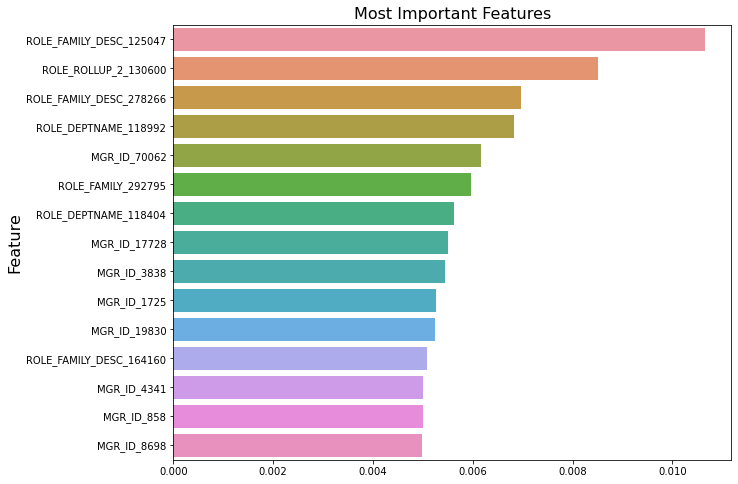

In [24]:
plot_feature_importance(feature_columns, xgb_clf.feature_importances_, top_n_features=15)

In [25]:
performance_measures(xgb_clf)

Mean Train MCC: 0.39076287637260154
Mean Test MCC: 0.22660323395234597
Mean Train ROC AUC Score: 0.8358825281806868
Mean Test ROC AUC Score: 0.7254743012261117


# **CatBoost**

In [26]:
from catboost import CatBoostClassifier

catboost_clf = CatBoostClassifier(loss_function='Logloss', iterations=500, depth=6, l2_leaf_reg=1, 
                                  cat_features=list(range(X_cb_train_transformed.shape[1])), 
                                  eval_metric='AUC', random_state=42, verbose=0)
catboost_clf.fit(X_cb_train_transformed, y_train)

In [27]:
performance_measures(catboost_clf, X_tr=X_cb_train_transformed, X_ts=X_cb_test_transformed)

Mean Train MCC: 0.4899121724824883
Mean Test MCC: 0.25841488658401285
Mean Train ROC AUC Score: 0.8815015986047451
Mean Test ROC AUC Score: 0.7782526101252574


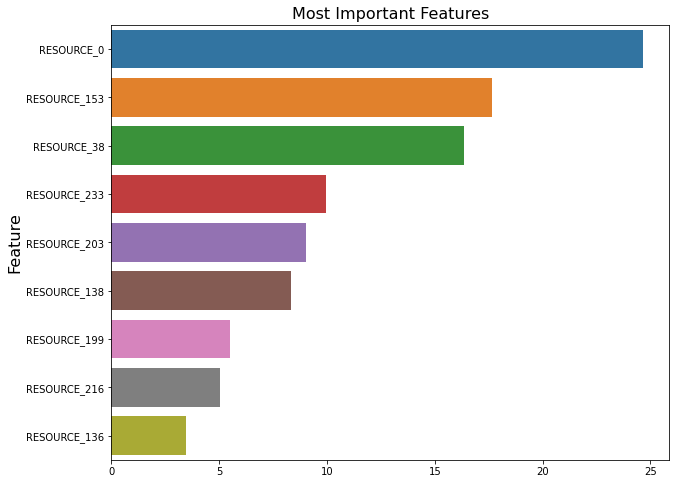

In [28]:
plot_feature_importance(feature_columns, catboost_clf.feature_importances_, top_n_features=15)

# **LightGBM**

In [29]:
from lightgbm import LGBMClassifier
model = LGBMClassifier()
model.fit(X_train_transformed, y_train)

LGBMClassifier()

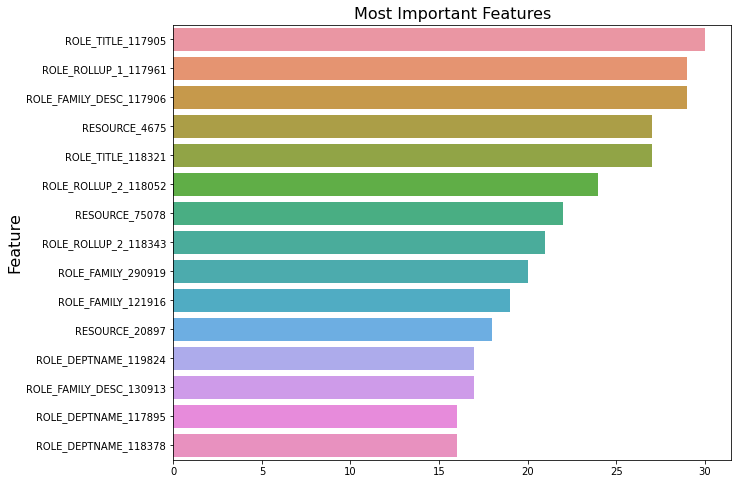

In [30]:
plot_feature_importance(feature_columns, model.feature_importances_, top_n_features=15)

In [31]:
performance_measures(model)

Mean Train MCC: 0.22872969209445185
Mean Test MCC: 0.1584894411305095
Mean Train ROC AUC Score: 0.8177179830855893
Mean Test ROC AUC Score: 0.7109834573207993


In [32]:
xgb_clf_pipeline = Pipeline([('pre_process', pre_process), ('xgb_clf', xgb_clf)])
catboost_clf_pipeline = Pipeline([('pre_process', cat_boost_pre_process), ('catboost_clf', catboost_clf)])
model_pipeline = Pipeline([('pre_process', pre_process), ('model', model)])

named_estimators = [('xgb_clf', xgb_clf_pipeline), ('catboost_clf', catboost_clf_pipeline), ('model', model_pipeline)]

## Model Evaluation

In [33]:
result_df = pd.DataFrame(results, columns=['Model', 'CV Train AUC Score', 'CV Test AUC Score', 'CV Train MCC', 'CV Test MCC'])
result_df

,Model,CV Train AUC Score,CV Test AUC Score,CV Train MCC,CV Test MCC
0,XGBClassifier,0.836,0.725,0.391,0.227
1,CatBoostClassifier,0.882,0.778,0.490,0.258
2,LGBMClassifier,0.818,0.711,0.229,0.158


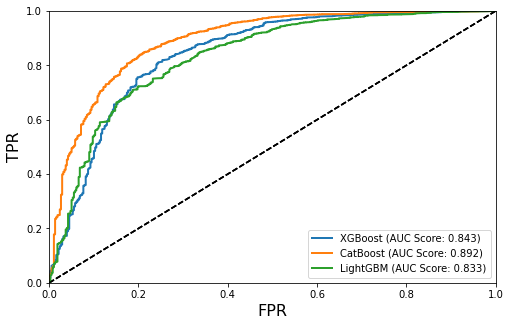

In [34]:
plt.figure(figsize=(8, 5))
plot_custom_roc_curve('XGBoost', y_test, xgb_clf.predict_proba(X_test_transformed)[:,1])
plot_custom_roc_curve('CatBoost', y_test, catboost_clf.predict_proba(X_cb_test_transformed)[:,1])
plot_custom_roc_curve('LightGBM', y_test, model.predict_proba(X_test_transformed)[:,1])
plt.show()